In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, mean_absolute_error

from model.mma_features import EasyPipeline

stats_df = pd.read_csv("data/clean_stats.csv")
bio_df = pd.read_csv("data/clean_bios.csv")
gender_df = pd.read_csv("data/fighter_genders.csv")
# ml_df = pd.read_csv("data/bfo_fighter_odds.csv") # i need an easy way to clean this
ml_df = pd.read_csv("data/clean_stats_plus_ml.csv")[[
    "Date", "FighterID", "OpponentID", 
    'FighterOpen', 'OpponentOpen',
    'FighterCloseLeft', 'FighterCloseRight', 'OpponentCloseLeft',
    'OpponentCloseRight',
]]

stats_df.columns

Index(['Date', 'Opponent', 'Event', 'FighterResult', 'SDBL/A', 'SDHL/A',
       'SDLL/A', 'TSL', 'TSA', 'SSL', 'SSA', 'TSL-TSA', 'KD', '%BODY', '%HEAD',
       '%LEG', 'OpponentID', 'SCBL', 'SCBA', 'SCHL', 'SCHA', 'SCLL', 'SCLA',
       'RV', 'SR', 'TDL', 'TDA', 'TDS', 'TK ACC', 'SGBL', 'SGBA', 'SGHL',
       'SGHA', 'SGLL', 'SGLA', 'AD', 'ADTB', 'ADHG', 'ADTM', 'ADTS', 'SM',
       'FighterID', 'SDBL', 'SDBA', 'SDHL', 'SDHA', 'SDLL', 'SDLA', 'Name',
       'stats_missing', 'Decision', 'Rnd', 'Time'],
      dtype='object')

In [2]:
easy_pipeline = EasyPipeline(stats_df=stats_df, ml_df=ml_df, bio_df=bio_df, gender_df=gender_df)

100%|███████████████████████████████████████| 4452/4452 [00:57<00:00, 77.80it/s]
/opt/anaconda3/envs/sports_pystan2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


For now, we're just doing PCA in-sample, so there's definitely a bit of data leakage here.

I'm also doing it outside of the pipeline in a weird way. One of these days we'll fix this.

In [3]:
from sklearn.decomposition import PCA

stat_cols = [
    'TSL', 'SSL',
    'KD', 
    'SCBL',
    'SCHL', 'SCLL', 'RV', 'TDL', 'TDS',
    'SGBL', 'SGHL', 'SGLL', 'AD', 'ADTB',
    'ADHG', 'ADTM', 'ADTS', 'SDBL', 'SDHL',
#     'SM', 
    'SDLL',
    #'time_seconds',
    'distance_strikes_landed', 'clinch_strikes_landed', 'standing_strikes',
    'ground_strikes_landed', 
#     'SM_success',
    
    'SCB_fails', 'SCH_fails', 'SCL_fails', 'SDB_fails', 'SDH_fails', 'SDL_fails',
    'SGB_fails', 'SGH_fails', 'SGL_fails', 'SS_fails', 'TD_fails', 'TS_fails',
    'SM_fails', 
]

def get_pca_train_data(stat_diff_df, diff_cols):
    pca = PCA(whiten=True)
    temp_pca_train_data = pd.concat([stat_diff_df[diff_cols], -stat_diff_df[diff_cols]])
    gender_vec = pd.concat([stat_diff_df["gender"], stat_diff_df["gender"]])
    is_m = gender_vec == "M"
    is_w = ~is_m
    m_scale = temp_pca_train_data.loc[is_m, diff_cols].std()
    w_scale = temp_pca_train_data.loc[is_w, diff_cols].std()
    temp_conditional_scale = (
        np.matrix(is_m).T * np.matrix(m_scale) + 
        np.matrix(is_w).T * np.matrix(w_scale)
    )
    temp_pca_train_data[diff_cols] /= temp_conditional_scale
    pca.fit(temp_pca_train_data)
    
    is_m = stat_diff_df["gender"] == "M"
    is_w = ~is_m
    conditional_scale = (
        np.matrix(is_m).T * np.matrix(m_scale) + 
        np.matrix(is_w).T * np.matrix(w_scale)
    )
    pca_train_data = pca.transform(stat_diff_df[diff_cols] / conditional_scale)
    return pca_train_data

def add_pca_fight_outcomes(stats_df, stat_cols):
    stat_diff_df = stats_df[["FighterID", "OpponentID", "Date", "gender"]].copy()
    diff_cols = [col+"_diff" for col in stat_cols]
    for col, diff_col in zip(stat_cols, diff_cols):
        stat_diff_df[diff_col] = np.sqrt(stats_df[col]) - \
                                 np.sqrt(stats_df[col+"_opp"])
    stat_diff_df = pd.DataFrame(stat_diff_df).dropna(subset=diff_cols).reset_index()
    
    pca_train_data = get_pca_train_data(stat_diff_df, diff_cols)
    pca_cols = ["PC_{}".format(i) for i in range(pca_train_data.shape[1])]
    stat_pca_df = pd.DataFrame(pca_train_data, columns=pca_cols)
    stat_pca_df = stat_pca_df.join(stat_diff_df[["FighterID", "OpponentID", "Date"]])
    return stat_pca_df

stat_pca_df = add_pca_fight_outcomes(easy_pipeline.pp_df, stat_cols)
easy_pipeline.pp_df = easy_pipeline.pp_df.merge(stat_pca_df, how="left", on=["FighterID", "OpponentID", "Date"])

In [4]:
real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
    "ordinal_fighter_result",
    "submission_fighter_result",
    "tko_ko_fighter_result",
    "decision_fighter_result",
    "finish_fighter_result",
    *[col for col in stat_pca_df.columns if col not in ["FighterID", "OpponentID", "Date"]],
]
diff_elo_target_cols = [
]

binary_elo_target_cols = ["Win"]

elo_alphas = {
    col: 0.45 for col in (real_elo_target_cols + diff_elo_target_cols + binary_elo_target_cols)
}

feat_ml_df = easy_pipeline.fit_transform_all(
    elo_alphas = elo_alphas, 
    real_elo_target_cols = real_elo_target_cols, 
    diff_elo_target_cols = diff_elo_target_cols,
    binary_elo_target_cols = binary_elo_target_cols,
    sqrt_diff_flag = True,
)

3116it [00:00, 7344.45it/s]
3116it [00:00, 5891.43it/s]
3116it [00:00, 6312.20it/s]
3116it [00:00, 6042.51it/s]
3116it [00:00, 5928.65it/s]
3116it [00:00, 6348.57it/s]
3116it [00:00, 4845.45it/s]
3116it [00:00, 5996.14it/s]
3116it [00:00, 6655.67it/s]
3116it [00:00, 6588.59it/s]
3116it [00:00, 6301.43it/s]
3116it [00:00, 6769.65it/s]
3116it [00:00, 6446.85it/s]
3116it [00:00, 6607.29it/s]
3116it [00:00, 6950.47it/s]
3116it [00:00, 6588.94it/s]
3116it [00:00, 6901.89it/s]
3116it [00:00, 6879.28it/s]
3116it [00:00, 6914.90it/s]
3116it [00:00, 6321.21it/s]
3116it [00:00, 6301.58it/s]
3116it [00:00, 5812.07it/s]
3116it [00:00, 6571.68it/s]
3116it [00:00, 6254.69it/s]
3116it [00:00, 6750.27it/s]
3116it [00:00, 6985.73it/s]
3116it [00:00, 5511.05it/s]
3116it [00:00, 6080.41it/s]
3116it [00:00, 6904.58it/s]
3116it [00:00, 6285.59it/s]
3116it [00:00, 7108.09it/s]
3116it [00:00, 6929.50it/s]
3116it [00:00, 7015.05it/s]
3116it [00:00, 6617.79it/s]
3116it [00:00, 7500.61it/s]
3116it [00:00, 6879.

In [5]:
feat_ml_df["Date"].max()

Timestamp('2022-03-26 00:00:00')

In [6]:
from model.mma_elo_model import inv_sigmoid

feat_ml_df["log_height_diff"] = np.log(feat_ml_df["imp_height"]) - np.log(feat_ml_df["imp_height_opp"])
feat_ml_df["log_age_diff"] = np.log(feat_ml_df["age"]) - np.log(feat_ml_df["age_opp"])
feat_ml_df["log_reach_diff"] = np.log(feat_ml_df["imp_reach"]) - np.log(feat_ml_df["imp_reach_opp"])
feat_ml_df["log_reach_diff"] = feat_ml_df["log_reach_diff"].fillna(0)
feat_ml_df["t_since_first_fight_diff"] = (feat_ml_df["t_since_first_fight"] - 
                                          feat_ml_df["t_since_first_fight_opp"])
feat_ml_df["log_t_since_first_fight_diff"] = (np.log(1 + feat_ml_df["t_since_first_fight"]) - 
                                              np.log(1 + feat_ml_df["t_since_first_fight_opp"]))

n_pca = 14
feat_cols = [
#     "oldEloDifffighter_result_time_left", 
#     "oldEloDiffml_logit_mvmt",
#     "oldEloDiffordinal_fighter_result",
#     "oldEloDiffsubmission_fighter_result",
#     "oldEloDifftko_ko_fighter_result",
#     "oldEloDiffdecision_fighter_result",
    "oldEloDifffinish_fighter_result", "oldEloDiffWin",
    *[f"oldEloDiffPC_{i}" for i in range(n_pca)],

    "t_since_last_fight_log_diff", 
#     "fights_per_day_diff",
#     "t_since_last_fight_diff",
#     "total_fights_sqrt_diff", 
#     "total_ufc_fights_diff",
    
    "age_diff", 
#     "log_age_diff",
#     "reach_diff", 
    "log_reach_diff",
    "weight_diff", 
#     "log_weight_diff",
    "height_diff",
#     "log_height_diff",
#     "ml_logit_mvmt",
    "log_t_since_first_fight_diff",
#     "quad_log_t_since_first_fight_diff",
]
print(feat_cols)

['oldEloDifffinish_fighter_result', 'oldEloDiffWin', 'oldEloDiffPC_0', 'oldEloDiffPC_1', 'oldEloDiffPC_2', 'oldEloDiffPC_3', 'oldEloDiffPC_4', 'oldEloDiffPC_5', 'oldEloDiffPC_6', 'oldEloDiffPC_7', 'oldEloDiffPC_8', 'oldEloDiffPC_9', 'oldEloDiffPC_10', 'oldEloDiffPC_11', 'oldEloDiffPC_12', 'oldEloDiffPC_13', 't_since_last_fight_log_diff', 'age_diff', 'log_reach_diff', 'weight_diff', 'height_diff', 'log_t_since_first_fight_diff']


In [7]:
from model.mma_log_reg_stan import SimpleSymmetricModel
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

mod = SimpleSymmetricModel(feat_cols=feat_cols, beta_prior_std=1.0, mcmc=False)

temp_df = feat_ml_df.dropna(subset=[*feat_cols, "targetWin"])

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2021-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col="p_fighter_implied")
preds_df = tscv.get_cross_val_preds(mod, temp_df)

training on date range: 2007-06-23 2020-12-19
Initial log joint probability = -5553.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      17      -1572.46   0.000275491     0.0408519           1           1       21   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-06-23 2021-01-16
Initial log joint probability = -5763.99
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      17      -1577.66   0.000498953     0.0371215           1           1       20   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-06-23 2021-01-20
Initial log joint probability = -5548.09
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      15      -1582.67   0.000319197     0.0329958           1           1   

training on date range: 2007-06-23 2021-07-17
Initial log joint probability = -6107.08
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      18      -1710.79   9.19318e-05     0.0207675           1           1       20   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-06-23 2021-07-24
Initial log joint probability = -5973.34
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      16      -1717.25   0.000533574     0.0410053           1           1       18   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-06-23 2021-07-31
Initial log joint probability = -7619.83
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      16      -1722.48   0.000145119     0.0178913           1           1   

Initial log joint probability = -6336.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      17      -1814.46   0.000156316     0.0335199           1           1       19   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-06-23 2021-12-04
Initial log joint probability = -6410.24
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      15      -1822.23   0.000132247     0.0621885       0.987       0.987       20   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-06-23 2021-12-11
Initial log joint probability = -7212.85
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      17      -1828.83   6.55785e-05     0.0424522      0.7212      0.7212       20   
Optimization terminated normally: 
 

In [8]:
from model_selection.metrics import KellyBet

def stupid_kelly_returns(fold_df, max_bankroll_fraction=0.05):
    y_pred = fold_df["y_pred"]
    KB = KellyBet(y_pred, fold_df, max_bankroll_fraction)
    # I'm not being very consistent with the defn of "return" here lol
    avg_kelly_return = KB.returns_df["total_return"].mean() 
    return avg_kelly_return

metrics_df = tscv.score_preds({"stupid_kelly": lambda x: stupid_kelly_returns(x, 1)})
metrics_df["stupid_kelly"].prod()

2.44652590834519

In [9]:
metrics_df["log_loss"].mean(), metrics_df["ml_log_loss"].mean()

(0.628613079434726, 0.6398526536414633)

In [10]:
metrics_df["accuracy_score"].mean(), metrics_df["ml_accuracy_score"].mean()

(0.6396714844295488, 0.621784801220285)

In [11]:
returns = metrics_df["stupid_kelly"] - 1
sharpe_ratio = returns.mean() / returns.std()

print("avg return: %.4f, std return: %.4f, sharpe ratio: %.4f"%(returns.mean(), returns.std(), sharpe_ratio))
ann_sharpe_ratio = sharpe_ratio * np.sqrt(52)
ann_sharpe_ratio

avg return: 0.0159, std return: 0.0528, sharpe ratio: 0.3019


2.177052020956103

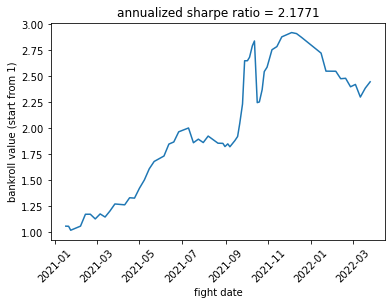

In [12]:
plt.plot(metrics_df["min_test_date"], metrics_df["stupid_kelly"].cumprod())
plt.ylabel("bankroll value (start from 1)")
plt.xticks(rotation=45)
plt.xlabel("fight date")
plt.title("annualized sharpe ratio = %.4f"%ann_sharpe_ratio)
plt.show()

<AxesSubplot:xlabel='ml_log_loss', ylabel='log_loss'>

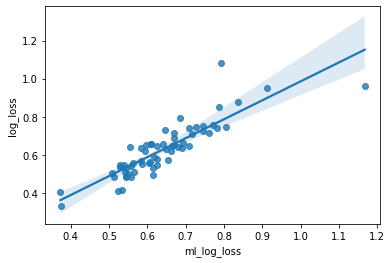

In [13]:
# oh, duh. that makes sense
sns.regplot(x="ml_log_loss", y="log_loss", data=metrics_df)

# HW Assignment

- [ ] Portfolio optimization based on kelly criterion for concurrent bets given predicted probabilities. Later we can figure out a better strategy. 
- [ ] Get returns from concurrent kelly criterion strategy, so that I can just plug it into my `TimeSeriesCrossVal.score_preds` method.

I've been pretty inconsistent with how I define "returns", so I'm kind of waiting to see how you define it. Then I'll start using that definition.

In [14]:
def kelly_bet_sizer(preds_df:pd.DataFrame) -> pd.DataFrame:
    """
    Size bets to maximize expected growth rate, ignore risk for now. 
    
    Accept: DataFrame with the following columns:
    * Date
    * FighterID
    * OpponentID
    * y_pred: predicted P(fighter wins) = 1 - P(opponent wins)
    * p_fighter: market-implied probability that fighter will win. Bet on 
        fighter if y_pred / p_fighter > 1
    * p_opponent: market-implied probability that opponent will win. Bet on
        opponent if (1 - y_pred) / p_opponent > 1
    Return: DataFrame with the following columns:
    * Date
    * FighterID
    * OpponentID
    * fighter_bet: % of portfolio to put on fighter
    * opponent_bet: % of portfolio to put on opponent
    
    Remainder from sum of portfolio %s for a given day is assumed to 
    stay in cash. 
    """
    display(preds_df[["Date", "FighterID", "OpponentID", "y_pred", "p_fighter", "p_opponent"]].head())
    raise NotImplementedError
    
kelly_bet_sizer(preds_df)

,Date,FighterID,OpponentID,y_pred,p_fighter,p_opponent
2531,2021-01-16,2335243/carlos-condit,2335666/matt-brown,0.619908,0.523810,0.523810
2532,2021-01-16,3010042/ramazan-emeev,3161786/david-zawada,0.736211,0.677419,0.357143
2533,2021-01-16,2614933/max-holloway,3164030/calvin-kattar,0.550224,0.574468,0.465116
2534,2021-01-16,3962563/alessio-di-chirico,4024714/joaquin-buckley,0.338602,0.298507,0.733333
2535,2021-01-16,4065639/wu-yanan,4397782/joselyne-edwards,0.663402,0.705882,0.327869


NotImplementedError: 

In [ ]:
def kelly_bet_returns(fold_df:pd.DataFrame) -> float:
    """
    Apply kelly_bet_sizer to fights on each Date, then see how it does.
    
    Accept: DataFrame with the following columns:
    * Date
    * FighterID
    * OpponentID
    * y_pred
    * fighter_payout
    * opponent_payout
    * targetWin: int, 1 if fighter wins, 0 if opponent wins. 
    Return: returns
    """
    raise NotImplementedError
    
tscv.score_preds({"better_kelly": kelly_bet_returns})